# Advanced Housing Dataset Exploration

1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

Eh, ToC needs work!!

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

Here we'll be considering the Ames Housing dataset, which is like the Boston Housing dataset, but better!!

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Principal Component Analysis???
  2. Univariate
  3. Lasso (L1)
  4. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56

housing = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [150]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['Id']

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

In [151]:
# # Scatter Plots for all features vs target

# for feature in train.columns:
#     if feature != 'SalePrice':
#         plt.figure(figsize = (1, 1))
#         sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
#         plt.title(f'Sale Price vs {feature}')
#         plt.show()

In [152]:
# # Let's try to do regression only for numerical features vs target

# count = 0

# for feature in train.columns:
#     if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
#         count += 1
#         plt.figure(figsize = (1, 1))
#         plt.title(f'Sale Price vs {feature}')
#         sns.regplot(x = feature, y = 'SalePrice', data = train)
#         plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

Before we start selecting and training models, we have to preprocess our data. This includes things like dealing with missing values, encoding categorical features, and scaling the data to a normal range.

In [153]:
display(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
902,903,60,RL,63.0,7875,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,180000
582,583,90,RL,81.0,11841,Grvl,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,118500
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000
294,295,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,167000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,589,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
511,512,120,RL,40.0,6792,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2006,New,Partial,202665
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


In [154]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [155]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,962.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,722.997432,57.769692,69.581081,10366.243151,6.136130,5.560788,1971.562500,1985.005993,107.097330,447.067637,...,94.319349,47.884418,21.190925,3.357021,14.476027,2.118151,31.184932,6.369007,2007.797089,182007.715753
std,423.305614,42.676269,23.584819,9521.150197,1.403068,1.114554,30.341521,20.727823,186.101196,439.722834,...,126.041240,66.999414,60.756700,30.336136,53.596363,36.482294,300.904002,2.741655,1.322442,79389.077813
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,356.500000,20.000000,58.000000,7559.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,711.500000,50.000000,69.000000,9504.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,382.000000,...,0.000000,27.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,164845.000000
75%,1090.250000,70.000000,80.000000,11645.000000,7.000000,6.000000,2001.000000,2004.000000,170.000000,732.250000,...,168.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215050.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000,755000.000000


## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [156]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     206
Alley          1094
FireplaceQu     543
PoolQC         1164
Fence           944
MiscFeature    1127
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,LotFrontage,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
902,63.0,NaN,Gd,NaN,NaN,NaN
582,81.0,NaN,NaN,NaN,NaN,NaN
429,130.0,NaN,TA,NaN,NaN,NaN
635,60.0,Pave,NaN,NaN,NaN,NaN
294,80.0,NaN,Gd,NaN,NaN,NaN
...,...,...,...,...,...,...
588,65.0,NaN,Gd,NaN,NaN,NaN
934,313.0,NaN,Gd,NaN,NaN,NaN
511,40.0,NaN,Gd,NaN,NaN,NaN
185,90.0,NaN,TA,NaN,GdPrv,NaN


All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [157]:
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
902,903,60,RL,7875,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,180000
582,583,90,RL,11841,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,118500
429,430,20,RL,11457,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,169,0,0,0,0,3,2009,WD,Normal,175000
635,636,190,RH,10896,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2007,WD,Abnorml,200000
294,295,20,RL,9600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2009,WD,Normal,167000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,589,20,RL,25095,Pave,IR1,Low,AllPub,Inside,Sev,...,0,0,60,0,0,6,2009,WD,Partial,143000
934,935,20,RL,27650,Pave,IR2,HLS,AllPub,Inside,Mod,...,0,0,0,0,0,11,2008,WD,Normal,242000
511,512,120,RL,6792,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2006,New,Partial,202665
185,186,75,RM,22950,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,410,0,0,6,2006,WD,Normal,475000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
559,560,120,RL,3196,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Normal,234000
43,44,20,RL,9200,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,130250
535,536,190,RL,7000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,148,0,0,0,0,1,2008,WD,Normal,107500
289,290,70,RL,8730,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,259,0,0,7,2007,WD,Normal,153575
355,356,20,RL,11249,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,177500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,280,60,RL,10005,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2008,WD,Normal,192000
164,165,40,RM,5400,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,183,0,0,0,0,10,2007,WD,Normal,152000
1279,1280,50,C (all),7500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,164,0,0,0,0,4,2010,COD,Abnorml,68400
1096,1097,70,RM,6882,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,115,0,0,0,0,3,2007,WD,Normal,127000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [158]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [159]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [160]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
902,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
582,RL,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
429,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
635,RH,Pave,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Feedr,Norm,...,FuseA,Fa,Typ,Attchd,Unf,TA,TA,N,WD,Abnorml
294,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,RL,Pave,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,...,SBrkr,Ex,Typ,Attchd,Unf,TA,TA,Y,WD,Partial
934,RL,Pave,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
511,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,New,Partial
185,RM,Pave,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,...,SBrkr,Ex,Typ,Detchd,Unf,Ex,TA,Y,WD,Normal


Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:  
1. LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [161]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [162]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
902,3.0,3,2,3,2,4,3,1,1,1,4,1,3,3,7,3,3,3,2
582,3.0,3,2,2,3,4,3,3,5,1,2,1,3,2,7,1,3,3,2
429,2.0,3,2,2,2,4,3,2,5,1,2,1,3,3,7,1,3,3,2
635,3.0,3,2,1,2,3,2,1,2,1,4,1,2,1,7,1,3,3,0
294,3.0,3,2,2,2,3,3,1,5,1,2,1,3,2,7,3,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2.0,3,0,2,2,3,3,4,5,1,4,1,3,4,7,1,3,3,2
934,0.0,3,1,2,2,4,3,4,5,1,4,1,3,3,7,2,3,3,2
511,2.0,3,2,3,2,4,3,1,1,1,4,1,3,3,7,2,3,3,2
185,0.0,3,2,3,3,3,3,2,1,1,4,1,3,4,7,1,5,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
559,3.0,3,2,3,2,4,3,4,1,1,4,1,3.0,3,7,3,3,3,2
43,2.0,3,2,2,2,4,3,3,2,3,2,1,3.0,2,7,1,3,3,2
535,3.0,3,2,2,2,4,3,4,5,1,2,1,3.0,2,7,1,3,3,0
289,3.0,3,2,2,2,3,3,1,1,1,4,1,2.0,2,7,1,3,3,2
355,0.0,3,2,3,3,4,4,1,4,3,4,1,3.0,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,3.0,3,2,2,2,4,3,1,3,1,4,1,3.0,2,7,3,3,3,2
164,3.0,3,2,2,3,3,3,2,2,1,3,1,2.0,3,7,1,3,3,2
1279,3.0,3,2,2,3,3,3,1,1,1,2,1,2.0,2,7,2,3,3,2
1096,3.0,3,2,2,2,3,3,1,1,1,2,1,3.0,3,7,1,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,3.0,3,2,2,2,3,3,1,4,2,2,1,3,2,7,1,3,3,2
1,2.0,3,2,2,2,3,3,1,4,1,2,1,3,3,7,1,3,3,2
2,2.0,3,2,2,2,4,3,1,5,1,3,1,3,2,7,3,3,3,2
3,2.0,3,2,2,2,3,3,1,5,1,4,1,3,3,7,3,3,3,2
4,2.0,3,2,3,2,4,3,1,4,1,4,1,3,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.0,3,2,2,2,3,3,1,1,1,3,1,3,2,7,1,3,3,2
1455,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,2
1456,3.0,3,2,2,2,3,3,1,4,1,4,1,3,2,7,1,3,3,2
1457,3.0,3,2,2,2,4,3,3,5,1,2,1,3,2,7,1,3,3,2


Ok, let's see what categorical features are left to deal with.

In [163]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,SaleType,SaleCondition
902,RL,Pave,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Attchd,WD,Normal
582,RL,Grvl,Lvl,Inside,Edwards,Norm,Norm,Duplex,SFoyer,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Attchd,WD,Normal
429,RL,Pave,Lvl,Corner,Timber,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,CBlock,GasA,Attchd,WD,Normal
635,RH,Pave,Bnk,Inside,SWISU,Feedr,Norm,2fmCon,2.5Fin,Hip,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Attchd,WD,Abnorml
294,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,Stone,CBlock,GasA,Attchd,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,RL,Pave,Low,Inside,ClearCr,Norm,Norm,1Fam,1Story,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,CBlock,GasA,Attchd,WD,Partial
934,RL,Pave,HLS,Inside,NAmes,PosA,Norm,1Fam,1Story,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,CBlock,GasA,Attchd,WD,Normal
511,RL,Pave,Lvl,Inside,NridgHt,Norm,Norm,TwnhsE,1Story,Gable,CompShg,VinylSd,VinylSd,Stone,PConc,GasA,Attchd,New,Partial
185,RM,Pave,Lvl,Inside,OldTown,Artery,Norm,1Fam,2.5Fin,Gable,WdShngl,Wd Sdng,Wd Sdng,None,BrkTil,GasA,Detchd,WD,Normal


Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!! HAHAHAHAHAHAHAHAHA.

One-Hot would be my next choice, but who has time for that???

In [164]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

,Id,MSSubClass,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.010372,-0.039340,0.062392,-0.015359,-0.007330,-0.015332,0.022332,-0.010490,-0.016178,...,-0.030091,0.016842,0.012799,-0.040161,-0.011502,0.031274,0.025598,0.020988,-0.004287,-0.008881
MSSubClass,0.010372,1.000000,-0.197301,0.094222,0.025918,0.034356,0.020531,-0.054121,0.036116,0.049830,...,-0.029996,-0.007431,-0.016860,-0.053265,-0.011048,0.007462,0.027397,-0.005484,-0.037937,-0.098814
LotArea,-0.039340,-0.197301,1.000000,-0.329109,-0.012330,-0.416232,0.117614,-0.008546,0.012606,0.025682,...,0.105006,0.075809,-0.014092,0.026729,0.032727,0.034935,0.036431,-0.002197,-0.029431,0.273396
LotShape,0.062392,0.094222,-0.329109,1.000000,0.027026,0.161880,-0.189046,0.023432,-0.223866,-0.173585,...,-0.141621,-0.099454,0.078144,-0.048705,-0.082974,0.010794,-0.012473,-0.016173,0.053320,-0.261170
Utilities,-0.015359,0.025918,-0.012330,0.027026,1.000000,-0.006490,0.002841,-0.011540,0.013090,0.038155,...,0.021915,-0.030647,0.010214,0.003241,-0.119403,0.001700,0.003035,0.057350,-0.026638,0.016418
LandSlope,-0.007330,0.034356,-0.416232,0.161880,-0.006490,1.000000,0.067343,-0.018187,0.082089,0.045194,...,-0.067534,0.045150,-0.005599,0.008333,-0.043913,0.012878,0.003181,0.011094,0.002429,-0.033221
OverallQual,-0.015332,0.020531,0.117614,-0.189046,0.002841,0.067343,1.000000,-0.081189,0.563430,0.556200,...,0.242780,0.310012,-0.113974,0.028290,0.063952,0.011504,-0.051193,0.073584,-0.016966,0.799408
OverallCond,0.022332,-0.054121,-0.008546,0.023432,-0.011540,-0.018187,-0.081189,1.000000,-0.376803,0.071330,...,-0.026633,-0.019557,0.075469,0.019848,0.064712,0.016872,0.023797,-0.017302,0.063315,-0.076684
YearBuilt,-0.010490,0.036116,0.012606,-0.223866,0.013090,0.082089,0.563430,-0.376803,1.000000,0.602836,...,0.238705,0.179888,-0.384912,0.038468,-0.056104,-0.020760,-0.033202,0.022503,-0.000506,0.522383
YearRemodAdd,-0.016178,0.049830,0.025682,-0.173585,0.038155,0.045194,0.556200,0.071330,0.602836,1.000000,...,0.199476,0.245294,-0.191652,0.048956,-0.038385,-0.007947,-0.032748,0.015145,0.055532,0.519801


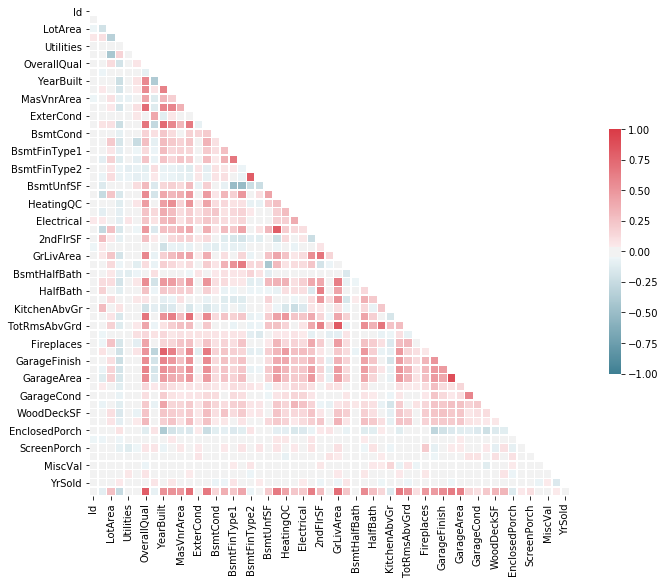

In [165]:
corr = train.corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [166]:
display(corr['SalePrice'].sort_values())

LotShape        -0.261170
KitchenAbvGr    -0.135793
EnclosedPorch   -0.126528
MSSubClass      -0.098814
OverallCond     -0.076684
BsmtFinType2    -0.056756
LandSlope       -0.033221
YrSold          -0.028892
LowQualFinSF    -0.027454
MiscVal         -0.022357
BsmtFinSF2      -0.020672
Id              -0.008881
BsmtHalfBath    -0.007834
Utilities        0.016418
PoolArea         0.026256
ExterCond        0.036595
MoSold           0.039830
3SsnPorch        0.054429
GarageCond       0.100675
ScreenPorch      0.105051
Functional       0.109129
BedroomAbvGr     0.142485
GarageQual       0.143254
BsmtCond         0.153398
BsmtUnfSF        0.217185
Electrical       0.223179
PavedDrive       0.225177
CentralAir       0.230722
BsmtFullBath     0.235213
BsmtFinType1     0.235755
LotArea          0.273396
HalfBath         0.281094
2ndFlrSF         0.295282
WoodDeckSF       0.321203
OpenPorchSF      0.326037
BsmtExposure     0.362260
BsmtFinSF1       0.410502
HeatingQC        0.425263
GarageYrBlt 

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [167]:
corr_sp = corr['SalePrice']
display(corr_sp)

print('')
columns_to_drop2 = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop2)

train.drop(columns_to_drop2, inplace = True, axis = 1)
valid.drop(columns_to_drop2, inplace = True, axis = 1)
test.drop(columns_to_drop2, inplace = True, axis = 1)

display(train)
display(valid)
display(test)

Id              -0.008881
MSSubClass      -0.098814
LotArea          0.273396
LotShape        -0.261170
Utilities        0.016418
LandSlope       -0.033221
OverallQual      0.799408
OverallCond     -0.076684
YearBuilt        0.522383
YearRemodAdd     0.519801
MasVnrArea       0.492135
ExterQual        0.696123
ExterCond        0.036595
BsmtQual         0.660886
BsmtCond         0.153398
BsmtExposure     0.362260
BsmtFinType1     0.235755
BsmtFinSF1       0.410502
BsmtFinType2    -0.056756
BsmtFinSF2      -0.020672
BsmtUnfSF        0.217185
TotalBsmtSF      0.649732
HeatingQC        0.425263
CentralAir       0.230722
Electrical       0.223179
1stFlrSF         0.626989
2ndFlrSF         0.295282
LowQualFinSF    -0.027454
GrLivArea        0.711428
BsmtFullBath     0.235213
BsmtHalfBath    -0.007834
FullBath         0.561258
HalfBath         0.281094
BedroomAbvGr     0.142485
KitchenAbvGr    -0.135793
KitchenQual      0.661324
TotRmsAbvGrd     0.527810
Functional       0.109129
Fireplaces  

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,SalePrice
902,7.0,2003.0,2003.0,3,4,783.0,807.0,1509.0,2.0,3,8.0,3,2.0,393.0,180000.0
582,6.0,1990.0,1990.0,2,4,816.0,816.0,816.0,1.0,2,5.0,1,0.0,0.0,118500.0
429,6.0,1988.0,1988.0,2,4,1392.0,1412.0,1412.0,2.0,3,6.0,1,2.0,576.0,175000.0
635,6.0,1914.0,1995.0,1,3,1440.0,1440.0,3395.0,2.0,1,14.0,1,0.0,0.0,200000.0
294,6.0,1953.0,1953.0,2,3,1416.0,1644.0,1644.0,1.0,2,7.0,3,2.0,418.0,167000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,5.0,1968.0,2003.0,2,3,1437.0,1473.0,1473.0,1.0,4,5.0,1,1.0,452.0,143000.0
934,7.0,1960.0,2007.0,2,4,585.0,2069.0,2069.0,2.0,3,9.0,2,2.0,505.0,242000.0
511,7.0,2005.0,2006.0,3,4,1368.0,1368.0,1368.0,2.0,3,6.0,2,2.0,474.0,202665.0
185,10.0,1892.0,1993.0,3,3,1107.0,1518.0,3608.0,2.0,4,12.0,1,3.0,840.0,475000.0


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,SalePrice
559,7.0,2003.0,2004.0,3,4,1374.0,1557.0,1557.0,2.0,3,7.0,3,2.0,420.0,234000.0
43,5.0,1975.0,1980.0,2,4,938.0,938.0,938.0,1.0,2,5.0,1,1.0,308.0,130250.0
535,5.0,1910.0,1991.0,2,4,1117.0,820.0,1347.0,1.0,2,5.0,1,0.0,0.0,107500.0
289,6.0,1915.0,2003.0,2,3,698.0,698.0,1396.0,1.0,2,7.0,1,1.0,384.0,153575.0
355,6.0,1995.0,1995.0,3,4,1200.0,1200.0,1200.0,2.0,3,6.0,2,2.0,521.0,177500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,7.0,1977.0,1977.0,2,4,1160.0,1156.0,2022.0,2.0,2,8.0,3,2.0,505.0,192000.0
164,6.0,1926.0,2004.0,2,3,1149.0,1149.0,1616.0,2.0,3,5.0,1,1.0,216.0,152000.0
1279,4.0,1920.0,1950.0,2,3,698.0,698.0,1128.0,1.0,2,6.0,2,2.0,528.0,68400.0
1096,6.0,1914.0,2006.0,2,3,684.0,773.0,1355.0,1.0,3,7.0,1,0.0,0.0,127000.0


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea
0,5.0,1961.0,1961.0,2,3,882.0,896.0,896.0,1.0,2,5.0,1,1.0,730.0
1,6.0,1958.0,1958.0,2,3,1329.0,1329.0,1329.0,1.0,3,6.0,1,1.0,312.0
2,5.0,1997.0,1998.0,2,4,928.0,928.0,1629.0,2.0,2,6.0,3,2.0,482.0
3,6.0,1998.0,1998.0,2,3,926.0,926.0,1604.0,2.0,3,7.0,3,2.0,470.0
4,8.0,1992.0,1992.0,3,4,1280.0,1280.0,1280.0,2.0,3,5.0,2,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,1970.0,1970.0,2,3,546.0,546.0,1092.0,1.0,2,5.0,1,0.0,0.0
1455,4.0,1970.0,1970.0,2,3,546.0,546.0,1092.0,1.0,2,6.0,1,1.0,286.0
1456,5.0,1960.0,1996.0,2,3,1224.0,1224.0,1224.0,1.0,2,7.0,1,2.0,576.0
1457,5.0,1992.0,1992.0,2,4,912.0,970.0,970.0,1.0,2,6.0,1,0.0,0.0


Now, we need to do some feature scaling!! Normalize this stuff.

For this, and later steps, we'll need to split out our X and y values.

We'll need to reverse transform our predictions before the end, so let's not forget that.

In [168]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

Ok, now we can scale the data. As always, only fit the the scaler on the TRAIN data, to prevent leakage.

Also, we have to do some reshaping to scale the y values.

Ok, having some trouble with scaling the data. Can't scale the y values for some reason.

I'll work on that later.

In [169]:
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_scaler.fit(X_train)
# y_scaler.fit(y_train.reshape(-1, 1))

# X_train = X_scaler.transform(X_train)
# X_valid = X_scaler.transform(X_valid)
# X_test = X_scaler.transform(X_test)

# y_train = np.squeeze(y_scaler.transform(y_train.reshape(-1, 1)))
# y_valid = np.squeeze(y_scaler.transform(y_valid.reshape(-1, 1)))

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Decision Tree

In [170]:
model1 = DecisionTreeRegressor()
model1.fit(X_train, y_train)

valid_pred1 = model1.predict(X_valid)
error1 = np.sqrt(mse(valid_pred1, y_valid))
display(f'RMSE for model1 is ${error1}')

'RMSE for model1 is $40708.8940528397'

Well, I guess this isn't the worst, but given that the average sale price is 181286.518836, we're looking at about 20% error on average.

Ok, let's upload to Kaggle and compare:

In [171]:
test_pred1 = model1.predict(X_test)

output1 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred1})

output1.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub1.csv',index=False, header =1)

model1 got a score of 0.23263, which is substantially worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

## Random Forest

Everyone knows random forest is way better than simple decision tree!!! Let's put that to the test.

In [172]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

valid_pred2 = model2.predict(X_valid)
error2 = np.sqrt(mse(valid_pred2, y_valid))
display(f'RMSE for model2 is ${error2}')

'RMSE for model2 is $33473.43285529584'

Alright, so far we're definitely beating Decision Tree. Let's also sumbit to Kaggle to see how we're doing.

In [173]:
test_pred2 = model2.predict(X_test)

output2 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred2})

output2.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub2.csv',index=False, header =1)

model2 got a score of 0.16133, which is a SUBSTANTIAL improvement over the decision tree. However, it's still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.


## XGBoost

XGBoost was the hottest model a few years ago. However, it's said to have been surpased by LightGBM these days. Let's find out!!!

Apparently XGBoost is dead on Anaconda. Vive la LightGBM!!!

## LightGBM

Let's test the new hotness.

In [174]:
model4 = lgb.LGBMRegressor()
model4.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20)



valid_pred4 = model4.predict(X_valid)
error4 = np.sqrt(mse(valid_pred4, y_valid))

print('')

display(f'RMSE for model4 is ${error4}')

[1]	valid_0's l2: 5.49923e+09
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 4.8003e+09
[3]	valid_0's l2: 4.24241e+09
[4]	valid_0's l2: 3.77464e+09
[5]	valid_0's l2: 3.35765e+09
[6]	valid_0's l2: 3.04383e+09
[7]	valid_0's l2: 2.7767e+09
[8]	valid_0's l2: 2.5414e+09
[9]	valid_0's l2: 2.36194e+09
[10]	valid_0's l2: 2.20896e+09
[11]	valid_0's l2: 2.08992e+09
[12]	valid_0's l2: 1.98901e+09
[13]	valid_0's l2: 1.89139e+09
[14]	valid_0's l2: 1.82292e+09
[15]	valid_0's l2: 1.75154e+09
[16]	valid_0's l2: 1.69356e+09
[17]	valid_0's l2: 1.64858e+09
[18]	valid_0's l2: 1.61181e+09
[19]	valid_0's l2: 1.57933e+09
[20]	valid_0's l2: 1.541e+09
[21]	valid_0's l2: 1.52079e+09
[22]	valid_0's l2: 1.49435e+09
[23]	valid_0's l2: 1.47443e+09
[24]	valid_0's l2: 1.4589e+09
[25]	valid_0's l2: 1.4433e+09
[26]	valid_0's l2: 1.43682e+09
[27]	valid_0's l2: 1.42581e+09
[28]	valid_0's l2: 1.41896e+09
[29]	valid_0's l2: 1.419e+09
[30]	valid_0's l2: 1.41069e+09
[31]	valid_0's l2: 1.40639e

'RMSE for model4 is $35946.387516412404'

Hmm, this is worse than Decision Tree. Oh well. Let's also sumbit to Kaggle to see how we're doing.

In [175]:
test_pred4 = model4.predict(X_test)

output4 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred4})

output4.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub4.csv',index=False, header =1)

model4 got a score of 0.16308, which is slightly worse than decision tree. It's also still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

We could likely improve with some hyperparameter tuning, but there are some other big picture improvements we could work on, like:

1.  k-fold validation
2.  Better feature generation and selection
3.  Then maybe some hyperparameter tuning

## LightGBM all by itself

Let's see how LightGBM does with minimal preprocessing. Just let it decide what to do.

In [176]:
housing1 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test1 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

train1, valid1 = train_test_split(housing1, test_size = .2)

In [177]:
# Ok, ordinal encoder doesn't work with NaN values. Crap. Let's do the missing value thing from above first

# Drop heavily empty columns
columns_to_drop = train1.columns[train1.isnull().sum() > len(train1) * .15]
train1.drop(columns_to_drop, inplace = True, axis = 1)
valid1.drop(columns_to_drop, inplace = True, axis = 1)
test1.drop(columns_to_drop, inplace = True, axis = 1)


# Also, drop the IDs
train1.drop('Id', inplace = True, axis = 1)
valid1.drop('Id', inplace = True, axis = 1)
test1.drop('Id', inplace = True, axis = 1)


# Impute the rest

num_columns = train1.select_dtypes(exclude=['object']).columns
cat_columns = train1.select_dtypes(include=['object']).columns

# Impute Categorical Values
train1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train1.loc[:, cat_columns])
valid1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid1.loc[:, cat_columns])
test1.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test1.loc[:, cat_columns])

# Impute Numerical Values
train1.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train1.loc[:, num_columns])
valid1.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid1.loc[:, num_columns])
test1.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test1.loc[:, num_columns.drop('SalePrice')])


display(train1)
display(valid1)
display(test1)

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
74,50.0,RM,5790.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,...,202.0,0.0,0.0,0.0,0.0,5.0,2010.0,WD,Normal,107400.0
832,60.0,RL,9548.0,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,...,0.0,0.0,0.0,0.0,0.0,1.0,2010.0,WD,Normal,237000.0
1023,120.0,RL,3182.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,...,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,WD,Normal,191000.0
572,60.0,RL,13159.0,Pave,IR1,HLS,AllPub,Corner,Gtl,Timber,...,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,New,Partial,224500.0
640,120.0,RL,12677.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0.0,0.0,0.0,0.0,0.0,4.0,2008.0,WD,Normal,274000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,80.0,RL,9947.0,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,WD,Normal,173000.0
1406,85.0,RL,8445.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,WD,Normal,133000.0
66,20.0,RL,19900.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0.0,0.0,0.0,0.0,0.0,7.0,2010.0,WD,Normal,180000.0
205,20.0,RL,11851.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,...,0.0,508.0,0.0,0.0,0.0,5.0,2009.0,WD,Normal,180500.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
130,60.0,RL,14200.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0.0,0.0,0.0,0.0,0.0,5.0,2006.0,WD,Normal,226000.0
852,75.0,RL,7128.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,0.0,0.0,126.0,0.0,0.0,8.0,2007.0,WD,Normal,164000.0
806,80.0,RL,9750.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0.0,0.0,0.0,0.0,0.0,10.0,2006.0,WD,Normal,135500.0
720,120.0,RL,6563.0,Pave,IR1,Low,AllPub,CulDSac,Mod,StoneBr,...,234.0,0.0,0.0,0.0,0.0,12.0,2006.0,WD,Normal,275000.0
1149,70.0,RM,9000.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,WD,Normal,143000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,20.0,RL,8816.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,...,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,WD,Normal,139000.0
1323,30.0,RL,5330.0,Pave,Reg,HLS,AllPub,Inside,Gtl,BrkSide,...,0.0,0.0,0.0,0.0,0.0,12.0,2009.0,WD,Normal,82500.0
642,80.0,RL,13860.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,WD,Normal,345000.0
1315,60.0,RL,11075.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,WD,Normal,206900.0


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20.0,RH,11622.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,WD,Normal
1,20.0,RL,14267.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,WD,Normal
2,60.0,RL,13830.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,WD,Normal
3,60.0,RL,9978.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,WD,Normal
4,120.0,RL,5005.0,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,RM,1936.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,WD,Normal
1455,160.0,RM,1894.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,WD,Abnorml
1456,20.0,RL,20000.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,WD,Abnorml
1457,85.0,RL,10441.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,WD,Normal


In [178]:
#LightGBM says it can handle categorical features without the need for integer or one-hot, but it wasn't doing it for me. Piece of trash.
# LightGBM is supposed to do well with integer encoding, so let's try that
# Was having trouble, so I encoded each seperately, when I really should only encode based on the train data

code1 = OrdinalEncoder()

train1.loc[:, cat_columns] = code1.fit_transform(train1.loc[:, cat_columns])
valid1.loc[:, cat_columns] = code1.fit_transform(valid1.loc[:, cat_columns])
test1.loc[:, cat_columns] = code1.fit_transform(test1.loc[:, cat_columns])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [179]:
display(train1)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
74,50.0,4.0,5790.0,1.0,3.0,3.0,0.0,0.0,0.0,17.0,...,202.0,0.0,0.0,0.0,0.0,5.0,2010.0,8.0,4.0,107400.0
832,60.0,3.0,9548.0,1.0,0.0,3.0,0.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2010.0,8.0,4.0,237000.0
1023,120.0,3.0,3182.0,1.0,3.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,8.0,4.0,191000.0
572,60.0,3.0,13159.0,1.0,0.0,1.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,6.0,5.0,224500.0
640,120.0,3.0,12677.0,1.0,0.0,3.0,0.0,4.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,4.0,2008.0,8.0,4.0,274000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,80.0,3.0,9947.0,1.0,0.0,3.0,0.0,1.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,8.0,4.0,173000.0
1406,85.0,3.0,8445.0,1.0,3.0,3.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,8.0,4.0,133000.0
66,20.0,3.0,19900.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,7.0,2010.0,8.0,4.0,180000.0
205,20.0,3.0,11851.0,1.0,3.0,3.0,0.0,0.0,0.0,8.0,...,0.0,508.0,0.0,0.0,0.0,5.0,2009.0,8.0,4.0,180500.0


In [180]:
X_train1 = train1.iloc[:, :-1]
y_train1 = train1.iloc[:, -1]

X_valid1 = valid1.iloc[:, :-1]
y_valid1 = valid1.iloc[:, -1]

X_test1 = test1

display(X_train1)


# X_train1 = pd.get_dummies(X_train1)
# X_valid1 = pd.get_dummies(X_valid1)
# X_test1 = pd.get_dummies(X_test1)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
74,50.0,4.0,5790.0,1.0,3.0,3.0,0.0,0.0,0.0,17.0,...,0.0,202.0,0.0,0.0,0.0,0.0,5.0,2010.0,8.0,4.0
832,60.0,3.0,9548.0,1.0,0.0,3.0,0.0,1.0,0.0,5.0,...,39.0,0.0,0.0,0.0,0.0,0.0,1.0,2010.0,8.0,4.0
1023,120.0,3.0,3182.0,1.0,3.0,3.0,0.0,4.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,8.0,4.0
572,60.0,3.0,13159.0,1.0,0.0,1.0,0.0,0.0,0.0,23.0,...,114.0,0.0,0.0,0.0,0.0,0.0,7.0,2009.0,6.0,5.0
640,120.0,3.0,12677.0,1.0,0.0,3.0,0.0,4.0,0.0,16.0,...,140.0,0.0,0.0,0.0,0.0,0.0,4.0,2008.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,80.0,3.0,9947.0,1.0,0.0,3.0,0.0,1.0,0.0,11.0,...,27.0,0.0,0.0,0.0,0.0,0.0,6.0,2009.0,8.0,4.0
1406,85.0,3.0,8445.0,1.0,3.0,3.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,8.0,4.0
66,20.0,3.0,19900.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2010.0,8.0,4.0
205,20.0,3.0,11851.0,1.0,3.0,3.0,0.0,0.0,0.0,8.0,...,34.0,0.0,508.0,0.0,0.0,0.0,5.0,2009.0,8.0,4.0


In [181]:
model5 = lgb.LGBMRegressor()
model5.fit(X_train1, y_train1,
            eval_set=[(X_valid1, y_valid1)],
            early_stopping_rounds=20, verbose = False)

valid_pred5 = model5.predict(X_valid1)
error5 = np.sqrt(mse(valid_pred5, y_valid1))

print('')

display(f'RMSE for model5 is ${error5}')

'RMSE for model5 is $33809.199616834594'

Interesting. Looks a fair bit worse (36333 vs 30552), but who knows! Likely because we put a lot of junk data in there. Worth comparing to see that, no matter how good your algorithm is, you need good data.  

Ok, not really, but until we get quantum computing, that will probably still be true. Sorry AutoML!!!

Let's get back to the data we already preprocessed, and see how much hyperparameter tuning can help. We'll start with a simple grid search, and compare to a random search.

# Reprocessing the Data

Ok, before we start tuning hardcore, let's get back some of those features we droped. I'm going to repreprocess the data. Here are some strategies.

## Keep everything but very empty columns, use my encoding where possible, otherwise use integer encoding.

In [182]:
housing2 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test2 = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

train2, valid2 = train_test_split(housing2, test_size = .2)

columns_to_drop2 = train2.columns[train2.isnull().sum() > len(train2) * .15]
train2.drop(columns_to_drop2, inplace = True, axis = 1)
valid2.drop(columns_to_drop2, inplace = True, axis = 1)
test2.drop(columns_to_drop2, inplace = True, axis = 1)

num_columns2 = train2.select_dtypes(exclude=['object']).columns
cat_columns2 = train2.select_dtypes(include=['object']).columns

# Impute Categorical Values
train2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train2.loc[:, cat_columns2])
valid2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid2.loc[:, cat_columns2])
test2.loc[:, cat_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test2.loc[:, cat_columns2])

# Impute Numerical Values
train2.loc[:, num_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train2.loc[:, num_columns2])
valid2.loc[:, num_columns2] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid2.loc[:, num_columns2])
test2.loc[:, num_columns2.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test2.loc[:, num_columns2.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    train2[ordinal_features[i]] = train2[ordinal_features[i]].map(ordinal_maps[i])
    valid2[ordinal_features[i]] = valid2[ordinal_features[i]].map(ordinal_maps[i])
    test2[ordinal_features[i]] = test2[ordinal_features[i]].map(ordinal_maps[i])

cat_columns2 = train2.select_dtypes(include=['object']).columns

display(train2)
display(valid2)
display(test2)

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1187,1188.0,20.0,RL,12461.0,Pave,3.0,Lvl,3,Corner,2,...,192.0,0.0,0.0,0.0,0.0,7.0,2006.0,WD,Normal,262000.0
733,734.0,20.0,RL,10000.0,Pave,3.0,Lvl,3,Corner,2,...,0.0,0.0,0.0,0.0,400.0,3.0,2009.0,WD,Normal,131400.0
999,1000.0,20.0,RL,6762.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,WD,Normal,206000.0
1268,1269.0,50.0,RL,14100.0,Pave,2.0,Lvl,3,Inside,1,...,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,WD,Normal,381000.0
1332,1333.0,20.0,RL,8877.0,Pave,3.0,Lvl,3,Inside,1,...,0.0,0.0,0.0,0.0,0.0,5.0,2009.0,WD,Normal,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402.0,20.0,RL,8767.0,Pave,2.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,New,Partial,164990.0
1199,1200.0,20.0,RL,11235.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,10.0,2006.0,WD,Normal,148000.0
1084,1085.0,60.0,RL,13031.0,Pave,0.0,Lvl,3,Corner,2,...,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,WD,Normal,187500.0
738,739.0,90.0,RL,10800.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,WD,Alloca,179000.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
292,293.0,50.0,RL,11409.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,160.0,0.0,0.0,1.0,2009.0,WD,Normal,131000.0
1040,1041.0,20.0,RL,13125.0,Pave,3.0,Lvl,3,Corner,2,...,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,WD,Normal,155000.0
1096,1097.0,70.0,RM,6882.0,Pave,3.0,Lvl,3,Inside,2,...,115.0,0.0,0.0,0.0,0.0,3.0,2007.0,WD,Normal,127000.0
189,190.0,120.0,RL,4923.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,224.0,0.0,0.0,8.0,2008.0,WD,Normal,286000.0
369,370.0,20.0,RL,9830.0,Pave,2.0,Lvl,3,Corner,2,...,0.0,0.0,182.0,0.0,0.0,3.0,2010.0,WD,Normal,162000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1367.0,60.0,RL,9179.0,Pave,2.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,WD,Abnorml,193000.0
457,458.0,20.0,RL,53227.0,Pave,2.0,Low,3,CulDSac,1,...,0.0,0.0,0.0,0.0,0.0,3.0,2008.0,WD,Normal,256000.0
540,541.0,20.0,RL,14601.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,WD,Normal,315000.0
60,61.0,20.0,RL,13072.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,5.0,2006.0,New,Partial,158000.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,20.0,RH,11622.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,WD,Normal
1,1462.0,20.0,RL,14267.0,Pave,2.0,Lvl,3,Corner,2,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,WD,Normal
2,1463.0,60.0,RL,13830.0,Pave,2.0,Lvl,3,Inside,2,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,WD,Normal
3,1464.0,60.0,RL,9978.0,Pave,2.0,Lvl,3,Inside,2,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,WD,Normal
4,1465.0,120.0,RL,5005.0,Pave,2.0,HLS,3,Inside,2,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915.0,160.0,RM,1936.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,WD,Normal
1455,2916.0,160.0,RM,1894.0,Pave,3.0,Lvl,3,Inside,2,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,WD,Abnorml
1456,2917.0,20.0,RL,20000.0,Pave,3.0,Lvl,3,Inside,2,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,WD,Abnorml
1457,2918.0,85.0,RL,10441.0,Pave,3.0,Lvl,3,Inside,2,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,WD,Normal


In [183]:
# #Ok, now let's one-hot these fools!
# train2 = pd.get_dummies(train2)
# valid2 = pd.get_dummies(valid2)
# test2 = pd.get_dummies(test2)

code2 = OrdinalEncoder()

train2.loc[:, cat_columns2] = code2.fit_transform(train2.loc[:, cat_columns2])
valid2.loc[:, cat_columns2] = code2.fit_transform(valid2.loc[:, cat_columns2])
test2.loc[:, cat_columns2] = code2.fit_transform(test2.loc[:, cat_columns2])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [184]:
display(train2)
display(valid2)
display(test2)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1187,1188.0,20.0,3.0,12461.0,1.0,3.0,3.0,3,0.0,2,...,192.0,0.0,0.0,0.0,0.0,7.0,2006.0,8.0,4.0,262000.0
733,734.0,20.0,3.0,10000.0,1.0,3.0,3.0,3,0.0,2,...,0.0,0.0,0.0,0.0,400.0,3.0,2009.0,8.0,4.0,131400.0
999,1000.0,20.0,3.0,6762.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,8.0,4.0,206000.0
1268,1269.0,50.0,3.0,14100.0,1.0,2.0,3.0,3,4.0,1,...,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,8.0,4.0,381000.0
1332,1333.0,20.0,3.0,8877.0,1.0,3.0,3.0,3,4.0,1,...,0.0,0.0,0.0,0.0,0.0,5.0,2009.0,8.0,4.0,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402.0,20.0,3.0,8767.0,1.0,2.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,6.0,5.0,164990.0
1199,1200.0,20.0,3.0,11235.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,10.0,2006.0,8.0,4.0,148000.0
1084,1085.0,60.0,3.0,13031.0,1.0,0.0,3.0,3,0.0,2,...,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,8.0,4.0,187500.0
738,739.0,90.0,3.0,10800.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,8.0,2.0,179000.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
292,293.0,50.0,3.0,11409.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,160.0,0.0,0.0,1.0,2009.0,6.0,3.0,131000.0
1040,1041.0,20.0,3.0,13125.0,1.0,3.0,3.0,3,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,6.0,3.0,155000.0
1096,1097.0,70.0,4.0,6882.0,1.0,3.0,3.0,3,4.0,2,...,115.0,0.0,0.0,0.0,0.0,3.0,2007.0,6.0,3.0,127000.0
189,190.0,120.0,3.0,4923.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,224.0,0.0,0.0,8.0,2008.0,6.0,3.0,286000.0
369,370.0,20.0,3.0,9830.0,1.0,2.0,3.0,3,0.0,2,...,0.0,0.0,182.0,0.0,0.0,3.0,2010.0,6.0,3.0,162000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1367.0,60.0,3.0,9179.0,1.0,2.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,6.0,0.0,193000.0
457,458.0,20.0,3.0,53227.0,1.0,2.0,2.0,3,1.0,1,...,0.0,0.0,0.0,0.0,0.0,3.0,2008.0,6.0,3.0,256000.0
540,541.0,20.0,3.0,14601.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,6.0,3.0,315000.0
60,61.0,20.0,3.0,13072.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,5.0,2006.0,5.0,4.0,158000.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,20.0,2.0,11622.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,8.0,4.0
1,1462.0,20.0,3.0,14267.0,1.0,2.0,3.0,3,0.0,2,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,8.0,4.0
2,1463.0,60.0,3.0,13830.0,1.0,2.0,3.0,3,4.0,2,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,8.0,4.0
3,1464.0,60.0,3.0,9978.0,1.0,2.0,3.0,3,4.0,2,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,8.0,4.0
4,1465.0,120.0,3.0,5005.0,1.0,2.0,1.0,3,4.0,2,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915.0,160.0,4.0,1936.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,8.0,4.0
1455,2916.0,160.0,4.0,1894.0,1.0,3.0,3.0,3,4.0,2,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,8.0,0.0
1456,2917.0,20.0,3.0,20000.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,8.0,0.0
1457,2918.0,85.0,3.0,10441.0,1.0,3.0,3.0,3,4.0,2,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,8.0,4.0


In [186]:
display(X_train2)
display(X_valid2)
display(X_test2)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1187,1188.0,20.0,3.0,12461.0,1.0,3.0,3.0,3,0.0,2,...,114.0,192.0,0.0,0.0,0.0,0.0,7.0,2006.0,8.0,4.0
733,734.0,20.0,3.0,10000.0,1.0,3.0,3.0,3,0.0,2,...,0.0,0.0,0.0,0.0,0.0,400.0,3.0,2009.0,8.0,4.0
999,1000.0,20.0,3.0,6762.0,1.0,3.0,3.0,3,4.0,2,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,8.0,4.0
1268,1269.0,50.0,3.0,14100.0,1.0,2.0,3.0,3,4.0,1,...,12.0,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,8.0,4.0
1332,1333.0,20.0,3.0,8877.0,1.0,3.0,3.0,3,4.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2009.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402.0,20.0,3.0,8767.0,1.0,2.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,6.0,5.0
1199,1200.0,20.0,3.0,11235.0,1.0,3.0,3.0,3,4.0,2,...,82.0,0.0,0.0,0.0,0.0,0.0,10.0,2006.0,8.0,4.0
1084,1085.0,60.0,3.0,13031.0,1.0,0.0,3.0,3,0.0,2,...,44.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0,8.0,4.0
738,739.0,90.0,3.0,10800.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,8.0,2.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
292,293.0,50.0,3.0,11409.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,160.0,0.0,0.0,1.0,2009.0,6.0,3.0
1040,1041.0,20.0,3.0,13125.0,1.0,3.0,3.0,3,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,6.0,3.0
1096,1097.0,70.0,4.0,6882.0,1.0,3.0,3.0,3,4.0,2,...,0.0,115.0,0.0,0.0,0.0,0.0,3.0,2007.0,6.0,3.0
189,190.0,120.0,3.0,4923.0,1.0,3.0,3.0,3,4.0,2,...,120.0,0.0,0.0,224.0,0.0,0.0,8.0,2008.0,6.0,3.0
369,370.0,20.0,3.0,9830.0,1.0,2.0,3.0,3,0.0,2,...,17.0,0.0,0.0,182.0,0.0,0.0,3.0,2010.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1367.0,60.0,3.0,9179.0,1.0,2.0,3.0,3,4.0,2,...,88.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,6.0,0.0
457,458.0,20.0,3.0,53227.0,1.0,2.0,2.0,3,1.0,1,...,137.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0,6.0,3.0
540,541.0,20.0,3.0,14601.0,1.0,3.0,3.0,3,4.0,2,...,68.0,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,6.0,3.0
60,61.0,20.0,3.0,13072.0,1.0,3.0,3.0,3,4.0,2,...,50.0,0.0,0.0,0.0,0.0,0.0,5.0,2006.0,5.0,4.0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461.0,20.0,2.0,11622.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,8.0,4.0
1,1462.0,20.0,3.0,14267.0,1.0,2.0,3.0,3,0.0,2,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,8.0,4.0
2,1463.0,60.0,3.0,13830.0,1.0,2.0,3.0,3,4.0,2,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,8.0,4.0
3,1464.0,60.0,3.0,9978.0,1.0,2.0,3.0,3,4.0,2,...,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,8.0,4.0
4,1465.0,120.0,3.0,5005.0,1.0,2.0,1.0,3,4.0,2,...,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915.0,160.0,4.0,1936.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,8.0,4.0
1455,2916.0,160.0,4.0,1894.0,1.0,3.0,3.0,3,4.0,2,...,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,8.0,0.0
1456,2917.0,20.0,3.0,20000.0,1.0,3.0,3.0,3,4.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,8.0,0.0
1457,2918.0,85.0,3.0,10441.0,1.0,3.0,3.0,3,4.0,2,...,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,8.0,4.0


Ok, let's train!!!

In [187]:
X_train2 = train2.iloc[:, :-1]
y_train2 = train2.iloc[:, -1]

X_valid2 = valid2.iloc[:, :-1]
y_valid2 = valid2.iloc[:, -1]

X_test2 = test2

model6 = lgb.LGBMRegressor()
model6.fit(X_train2, y_train2,
            eval_set=[(X_valid2, y_valid2)],
            early_stopping_rounds=20, verbose = False)

valid_pred6 = model6.predict(X_valid2)
error6 = np.sqrt(mse(valid_pred6, y_valid2))

print('')

display(f'RMSE for model5 is ${error6}')

'RMSE for model5 is $22915.280113492805'

Holy crap!!! We're down to 22915!!! That's Way freaking better than anything else so far!!!  

Damn, I'm good.  

Let's see how it perform on Kaggle.

In [188]:
test_pred6 = model6.predict(X_test2)

output6 = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred6})

output6.to_csv(r'D:/code/Data/advanced_housing_submissions/advhousesub6.csv',index=False, header =1)

Crap! Still not an improvement on Kaggle, though better than anything else we've tried in this kernal.

Kaggle: 0.14104
    
Probably still comes down to preprocessing, but let's try a little hyp tuning and see what we can do. We could also do cross - validation. Oh, and I still need to normalize the data.

## Grid Search

Note that a lot of this is taken from an excellent Kaggle kernal. Hopefully I'll be able to dive into each of these features and understand them more in time.

https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761#Model-fitting-with-HyperParameter-optimisation

In [214]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3



fit_params={#"early_stopping_rounds":30, 
            "eval_metric" : 'r2', 
            "eval_set" : [(X_valid2, y_valid2)],
            #'eval_names': ['valid'], 
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
           }

param_test ={'num_leaves': range(6, 10), 
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }


#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100



model7 = lgb.LGBMRegressor(max_depth=-1, random_state=1729, silent=True, metric='None', n_jobs=4, n_estimators=5000)



gs = gscv(
    estimator=model7, param_grid=param_test, 
    scoring='r2',
    cv=3,
    refit=True,
    verbose=True)

gs.fit(X_train2, y_train2, **fit_params)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   59.8s finished


Best score reached: 0.8440729170532899 with params: {'num_leaves': 7} 


In [206]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Assessing our Results

Now that we've finished training one model from beginning to end, let's test it by uploading our results to Kaggle and see how we did.

# Developing a Pipeline

We went through a lot of steps to prepare our data and train our model. Let's condense as much of that as possible into a single pipeline that we can use for future datasets.

# Developing More Pipelines

This pipeline did ok, but surely we can do better if we tweak some of our steps. Let's develop some more pipelines from beginning to end, and compare the results of each.

# Comparing Models